# Plotting FESOM data on HEALPix grid 
Written by Bimo Niraula, based on initial codes by Boris Shapkin.

In this script, we can plot single output files (by linking to the grib file directly) 
or all the outputs found within a fdb directory. For all resolutions Healpix.

Written such that most of the common FESOM ocean variables have fitting colorbars/labels, but other variables might cause issues.


In [1]:
import healpy as hp
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cf
import eccodes as ec
import os
import sys
import glob

In [2]:
## Important distinction, now we are using Nested healpix also for FESOM
Nested=True

In [3]:
def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    Plots a variable on a Healpix.

    Args:
        var (array-like): Variable on Healpix coordinates (e.g., numpy array).
        nx (int, optional): Image resolution in the x-direction (default is 1000).
        ny (int, optional): Image resolution in the y-direction (default is 1000).
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If not provided,
            the current axis will be used (default is None).
        **kwargs: Additional arguments to pass to the imshow function.
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=Nested, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)

In [4]:
def worldmap(var,cbar,clabel = None,**kwargs):
    """
    Plot a variable on a Robinson projection world map.

    The function creates a Robinson projection world map using the provided variable
    'var'. 
    
    Args:
        var (array-like): The variable to be plotted on the world map.
        cbar (bool): A boolean flag to indicate whether to display the colorbar. If True,
            a colorbar will be shown; otherwise, no colorbar will be displayed.
        **kwargs: Additional keyword arguments to pass to the `nnshow` function.
    """
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(14, 7), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if cbar is not False:
        cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
        if clabel == None: # Set the label for the colorbar
            cbar.set_label("SST")
        else:
            cbar.set_label(clabel)  

In [5]:
def plot_healpix(data_healpix,
                 proj = 'mercator',
                 extent = None,
                 interactive = False,
                 cmap=cm.Spectral_r,
                 cbar = False,
                 clabel = None,
                 vmin = None,vmax = None,
                 savefig = False,
                savepath = None, closefile = False):
    
    """
    Plots data on a Healpix grid with various customization options.

    The function takes data defined on a Healpix grid and visualizes it on a specified
    map projection. 
    Args:
        data_healpix (array-like): Data on a Healpix grid.
        proj (str, optional): The map projection to use. Supported options are 'mercator',
            'np' (North Polar Stereographic), and 'sp' (South Polar Stereographic).
            Default is 'mercator'.
        extent (list, optional): The extent of the plot specified as ([min_lon, max_lon,
            min_lat, max_lat]) in degrees. Default is None, which shows the global extent.
        interactive (bool, optional): If True, the plot is displayed interactively with
            widgets for zooming and panning. If False, a static image is displayed.
            Default is False.
        cmap (colormap, optional): The colormap to use for the plot. Default is 'Spectral_r'.
        cbar (bool, optional): If True, a colorbar is displayed. If False, no colorbar is shown.
            Default is False.
        vmin (float, optional): The lower limit for the color scale. If not provided, the
            minimum value in 'data_healpix' will be used.
        vmax (float, optional): The upper limit for the color scale. If not provided, the
            maximum value in 'data_healpix' will be used.
        savefig (bool, optional): If True, the plot is saved as an image. If False, the plot
            is not saved. Default is False.
        savepath (str, optional): The path to save the image file. Default is None, which
            saves the image in the current working directory.
    """
    if vmin is None:
        vmin = np.nanmin(data_healpix)
    if vmax is None:
        vmax = np.nanmax(data_healpix)
    if interactive == False:
        %matplotlib inline

        if extent == None:
            worldmap(data_healpix, cbar,clabel=clabel,cmap=cmap,vmin = vmin, vmax = vmax)
        else:
            if proj == 'mercator':
                projection = ccrs.Mercator(central_longitude=0)
            elif proj == 'np':
                projection = ccrs.NorthPolarStereo(central_longitude=0)
            elif proj == 'sp':
                 projection = ccrs.SouthPolarStereo(central_longitude=0)
            fig, ax = plt.subplots(
                figsize=(14, 10), subplot_kw={"projection": projection}, constrained_layout=True
            )
            ax.set_extent(extent, ccrs.PlateCarree())
            nnshow(data_healpix, ax=ax, cmap=cmap,vmin = vmin, vmax = vmax)
            ax.add_feature(cf.COASTLINE, linewidth=0.8)
            
            # Add a colorbar to the plot
            if cbar is not False:
                cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
                if clabel== None: # Set the label for the colorbar
                    cbar.set_label("SST")
                else:
                    cbar.set_label(clabel)  
    else:
        %matplotlib widget
        hp.mollzoom(data_healpix,
                    flip="geo",
                    cmap =cmap,
                    min = vmin, max = vmax,
                    title=clabel,nest=Nested)
    if savefig == True:
        plt.savefig(savepath,dpi = 500, format = 'jpg')
    if closefile == True:
        plt.close()
    else:
        plt.show()

In [6]:
def plotafterextract_healpix(prefix,varname,data_healpix,date,FiguresDir,closefile=False):

    ##Moving the Plotting part from the function downstairs here so we can handle multiple messages in a
    ##file better. This just handles the different labels, colormaps etc

    #Setting labels, colormap based on the variables. If we want to plot other variables, can add here
    label="";colmap='vivid';vmin=np.nan; vmax=np.nan;shouldweplot=0  #Just defaults, in case sth fails
    if varname=="avg_tos":
        label="SST (°C)"
        colmap='coolwarm'
        vmin=-2; vmax=33
        shouldweplot=1
    if varname=="avg_sos":
        label="Sea Surface Salinity (psu)"
        #colmap='YlGnBu'
        colmap='terrain_r'
        vmin=3; vmax=41
        shouldweplot=1
    if varname=="avg_zos":
        label="Sea Surface Height (m)"
        colmap='YlGnBu_r'
        vmin=np.nan; vmax=np.nan
        shouldweplot=1

    dataOG=data_healpix
    data_healpix[data_healpix>1000]=np.nan

    #For proper file labeling:
    Figpath=FiguresDir+"FESOM_Hlpx_"+prefix
    
    if (varname=="avg_siconc") or (varname=="avg_sisnthick") or (varname=="avg_sithick"):
        fname=Figpath+'_NorthPole_'+varname+'_for_'+str(date)+'.jpeg'
        plot_healpix(data_healpix, extent = [-180,180,50,90], proj = 'np', cbar = True,clabel= varname,cmap='Blues_r', savefig=True,savepath=fname,closefile=closefile)

        fname=Figpath+'_SouthPole_'+varname+'_for_'+str(date)+'.jpeg'
        plot_healpix(data_healpix, extent = [-180,180,-50,-90], proj = 'sp', cbar = True,clabel= varname,cmap='Blues_r', savefig=True,savepath=fname,closefile=closefile)

    if (shouldweplot==1):           
        fname=Figpath+'_'+varname+'_for_'+str(date)+'.jpg'
        plot_healpix(data_healpix,cbar=True,clabel= label,cmap=colmap,savefig=True,savepath=fname, vmin=vmin, vmax=vmax,closefile=closefile)

    if(closefile==True): print('Figure plotted in given path, but not shown here.')

In [7]:

def extract_healpix(Inputfile,FiguresDir,closefile=False):
    '''Opens a healpix file, extracts the data (from different messages) and sends them to be plotted.
    Give FigureDirectory to plot at a good location (can add prefix to label those files).
    Colormap and limits are fixed here for some select variables. Can change as needed.
    Closefile control for whether or not to see figures 'inline' (for jupyterhub)
    '''
    
    ## Extrcting part:
    prefix=os.path.basename(Inputfile)[0:4]  #High or standard healpix?
    fin = open(Inputfile, 'rb')
    while 1:
            gid = ec.codes_grib_new_from_file(fin)
            if gid is None:
                break
            try:
                varname=(ec.codes_get(gid,"shortName"))
                date=(ec.codes_get(gid,"date"))
                data_healpix=ec.codes_get_values(gid)
                print('Extracting',varname,' for ',date )
                plotafterextract_healpix(prefix,varname,data_healpix,date,FiguresDir,closefile=closefile)
        
            except KeyValueNotFoundError as err:
                # Full list of exceptions here:
                #   https://confluence.ecmwf.int/display/ECC/Python+exception+classes
                print('  Key="%s" was not found: %s' % (key, err.msg))
            except CodesInternalError as err:
                print('Error with key="%s" : %s' % (key, err.msg))
                os.path.basename(Inputfile)[0:3]
    fin.close()

Extracting avg_tos  for  19900101


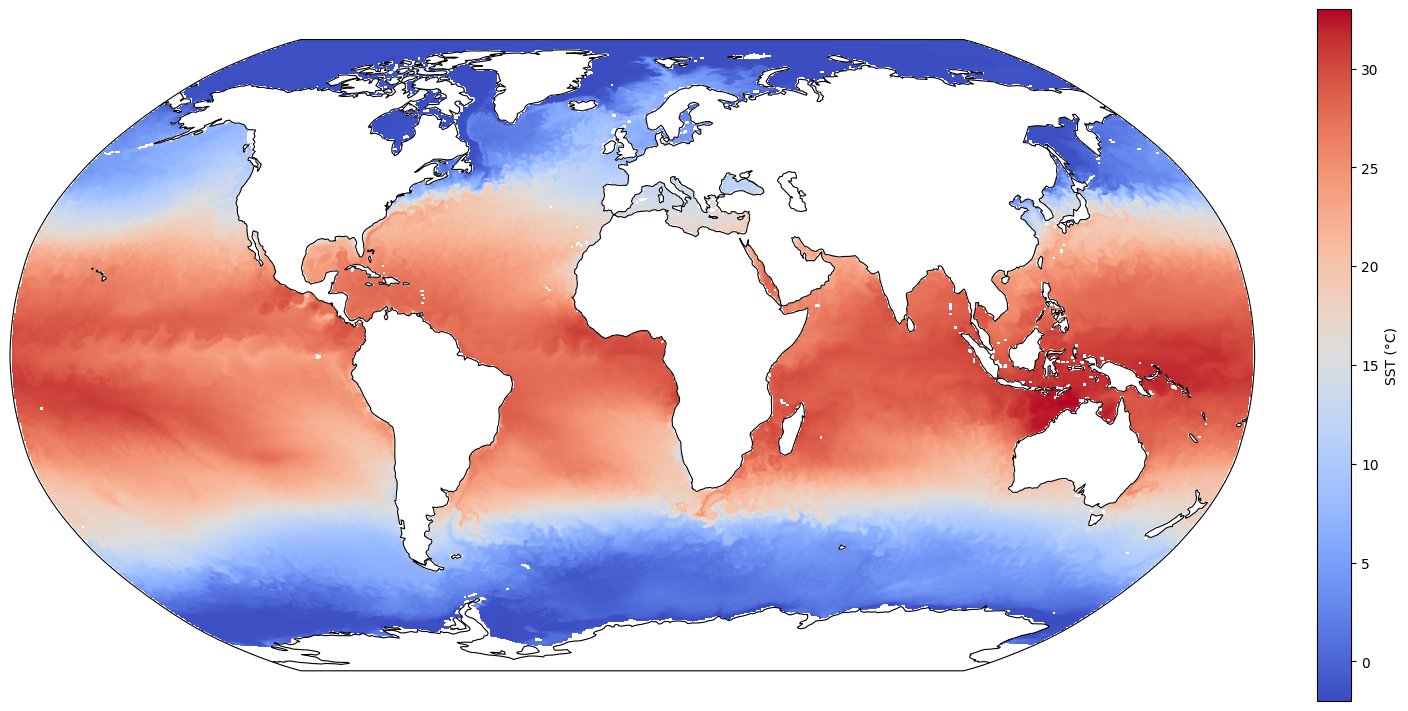

Extracting avg_sithick  for  19900101


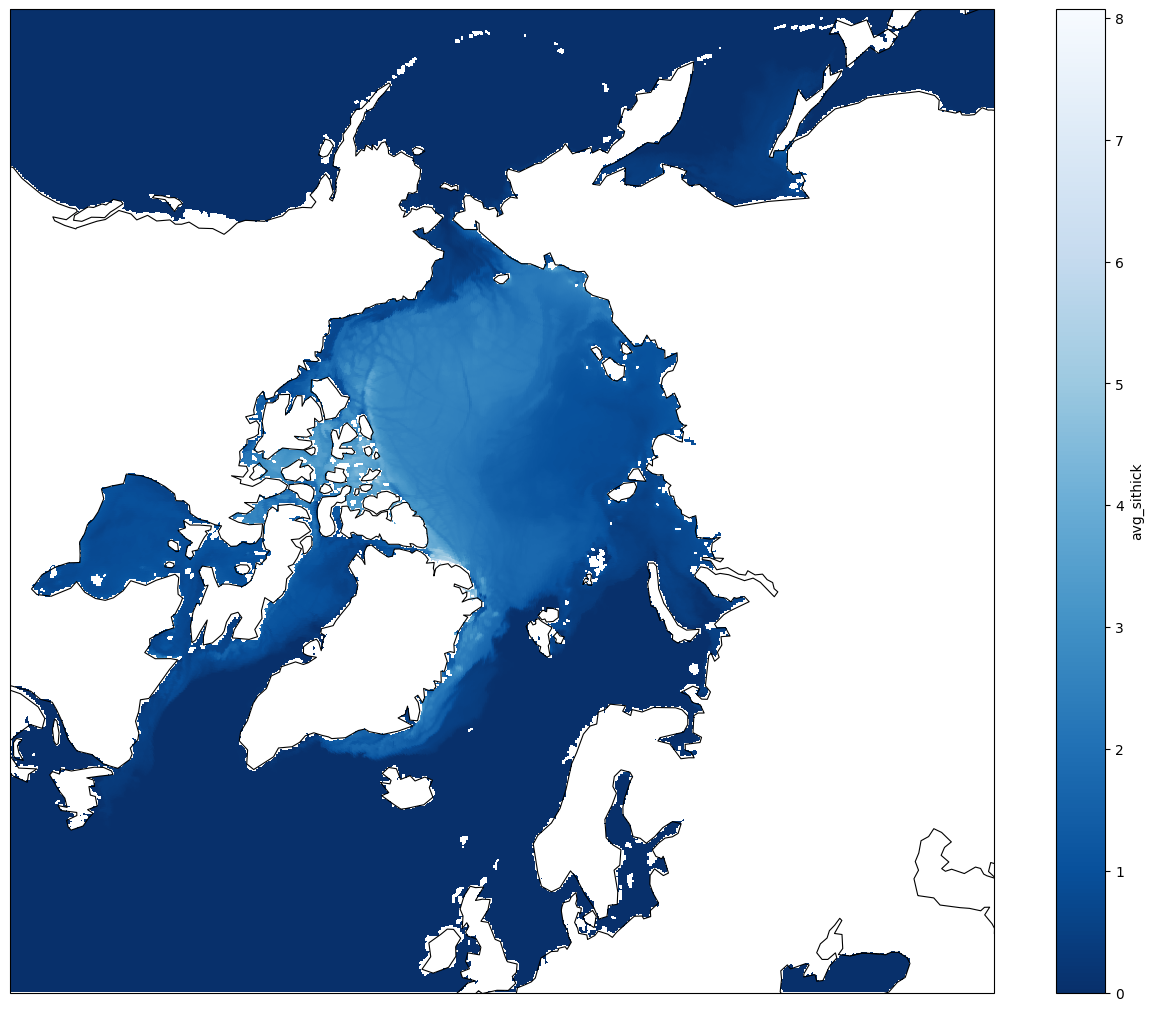

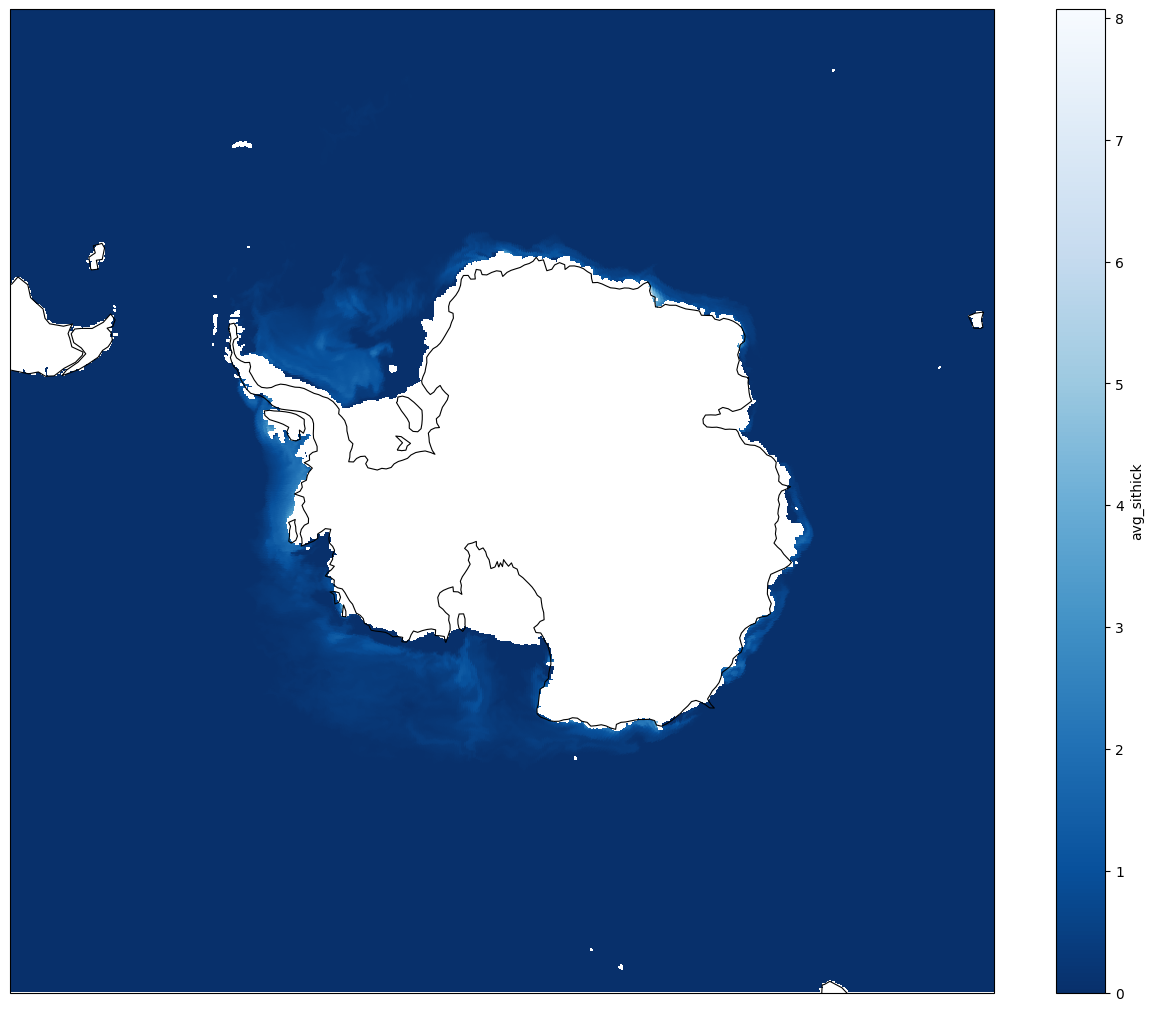

In [8]:
# Plotting a single file:
# Here we are using all paths for LUMI only. 
Inputfile="/pfs/lustrep3/scratch/project_465000454/sbeyer/rundir/tco1279l137/i2hm/hres/cray.craympich/lum-g.cray.sp/h72.N32.T240xt7xh1+ioT8xt7xh0.nextgems_6h.i32r0w32.htco1279-32nodes-6108022/fdb/HEALPix_grids/root/d1:climate-dt:CMIP6:hist:1:IFS-FESOM:1:i2hm:clte:19900101/high:fc:o2d.20240214.221603.nid007977.477437154557960.data"
extract_healpix(Inputfile,"/users/niraulab/Data/Figures/Testplot_tco1279_HresHPix",closefile=False)

In [ ]:
Inputfile="/pfs/lustrep3/scratch/project_465000454/sbeyer/test_fdb_tco79_historic/HEALPix_grids/root/d1:climate-dt:CMIP6:hist:1:IFS-FESOM:1:awi0:clte:19991218/standard:fc:o2d.20240217.020043.nid006059.182239757341369.data"
Inputfile="/pfs/lustrep3/scratch/project_465000454/sbeyer/test_fdb_tco79_historic/HEALPix_grids/root/d1:climate-dt:CMIP6:hist:1:IFS-FESOM:1:awi0:clte:19970408/standard:fc:o2d.20240216.220327.nid006214.487534622672085.data"
Inputfile="/pfs/lustrep3/scratch/project_465000454/sbeyer/test_fdb_tco79_historic/HEALPix_grids/root/d1:climate-dt:CMIP6:hist:1:IFS-FESOM:1:awi0:clte:19990401/standard:fc:o2d.20240217.010630.nid006163.62392989910131.data"
extract_healpix(Inputfile,"/users/niraulab/Data/Figures/NewTestFDB_F19_",closefile=True)

In [ ]:
# This set of codes goes through all output grib files from a set of runs and get figures.
# The subdirectory arrangement may differ for your needs.

# Directory containing the files
MainOutputDir = "/pfs/lustrep3/scratch/project_465000454/sbeyer/rundir/tco1279l137/i2hm/hres/cray.craympich/lum-g.cray.sp/h72.N32.T240xt7xh1+ioT8xt7xh0.nextgems_6h.i32r0w32.htco1279-32nodes-6108022"
Figpath="/users/niraulab/Data/Figures/"


components = os.path.normpath(MainOutputDir).split(os.path.sep)
if(components[-1]!= 'root') & (components[-2]!='HEALPix_grids') & (components[-3]!='fdb'):
    output_path=MainOutputDir+'/fdb/HEALPix_grids/root/'
if not os.path.isdir(output_path):
    print("Healpix output dir not found... Expected here: ",output_path)
else:
    print("Healpix output directory found!")

'''if not os.path.isdir(Figpath):
    print("Figures output directory not found. Expected here: ")
else:
    print("Figures will be saved here:")
print(Figpath)'''

for subdir in os.listdir(output_path):
    subdir_path = os.path.join(output_path, subdir)
    # Check if the item in Path1 is a directory
    if os.path.isdir(subdir_path):
        file_list = glob.glob(os.path.join(subdir_path, "*o2d*.data"))        
        #print(file_list)
    for file_path in file_list:
        try:
            extract_healpix(file_path,Figpath,closefile=True)
        except Exception as e:
            # Handle the exception gracefully
            print(f"An error occurred : {e}")
            print("In this file: ",file_path)
            # Optionally, continue to the next iteration of the loop
            continue